In [2]:
# !pip-compile --strip-extras requirements.in
# %pip install -r requirements.txt

In [ ]:
import torch
import torchaudio

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH
from torchaudio.transforms import MelSpectrogram
from transformers import Trainer, TrainingArguments
from datasets import load_dataset, Dataset, DatasetDict
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

2025-06-04 19:40:24.564288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset LibriSpeech (dev-clean)
train_dataset = LIBRISPEECH("./datasets", url="dev-clean", download=False) # Jika blm punya dataset, bisa set True
test_dataset = LIBRISPEECH("./datasets", url="test-clean", download=False)

In [6]:
train_dataset[0]

(tensor([[0.0012, 0.0014, 0.0014,  ..., 0.0000, 0.0000, 0.0002]]),
 16000,
 'HE HAD NEVER BEEN FATHER LOVER HUSBAND FRIEND',
 174,
 168635,
 0)

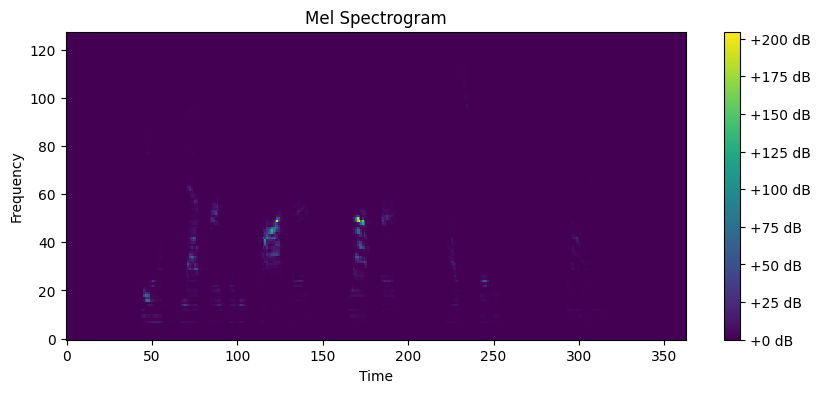

In [ ]:
# Pilih file audio dari dataset (misal, file pertama dari train_dataset)
waveform, sample_rate, transcript, _, _, _ = train_dataset[0]  # Ambil contoh dari dataset

# Konversi audio menjadi Mel Spectrogram
mel_spectrogram = MelSpectrogram()(waveform)

# Plot Mel Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram[0].numpy(), cmap='viridis', origin='lower', aspect='auto', interpolation='none')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()


Transcript: HE HAD NEVER BEEN FATHER LOVER HUSBAND FRIEND


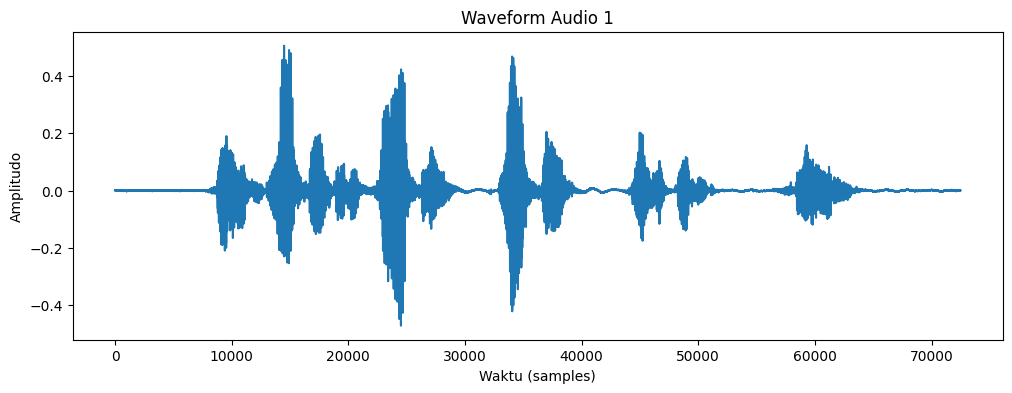

Transcript: THE HEART OF THAT EX CONVICT WAS FULL OF VIRGINITY


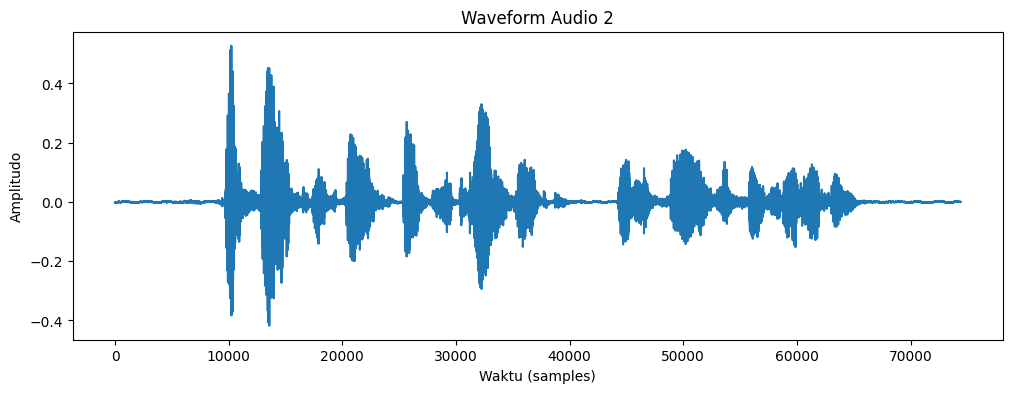

Transcript: HIS SISTER AND HIS SISTER'S CHILDREN HAD LEFT HIM ONLY A VAGUE AND FAR OFF MEMORY WHICH HAD FINALLY ALMOST COMPLETELY VANISHED HE HAD MADE EVERY EFFORT TO FIND THEM AND NOT HAVING BEEN ABLE TO FIND THEM HE HAD FORGOTTEN THEM


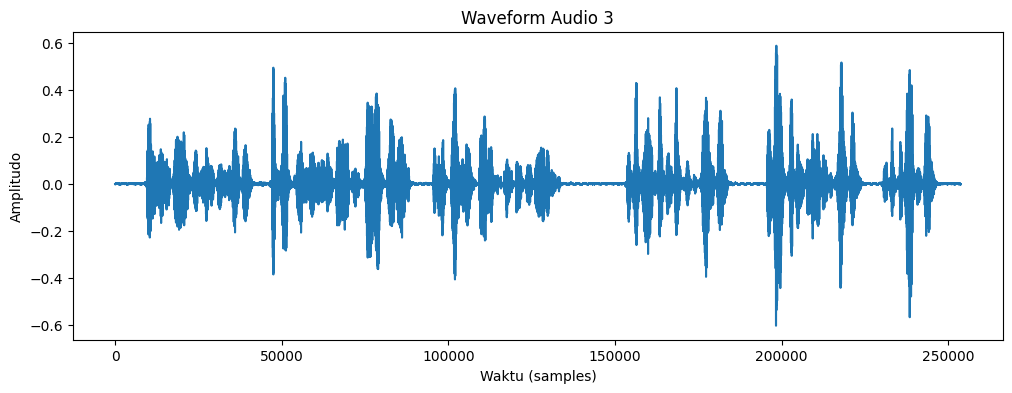

Transcript: HE SUFFERED ALL THE PANGS OF A MOTHER AND HE KNEW NOT WHAT IT MEANT FOR THAT GREAT AND SINGULAR MOVEMENT OF A HEART WHICH BEGINS TO LOVE IS A VERY OBSCURE AND A VERY SWEET THING


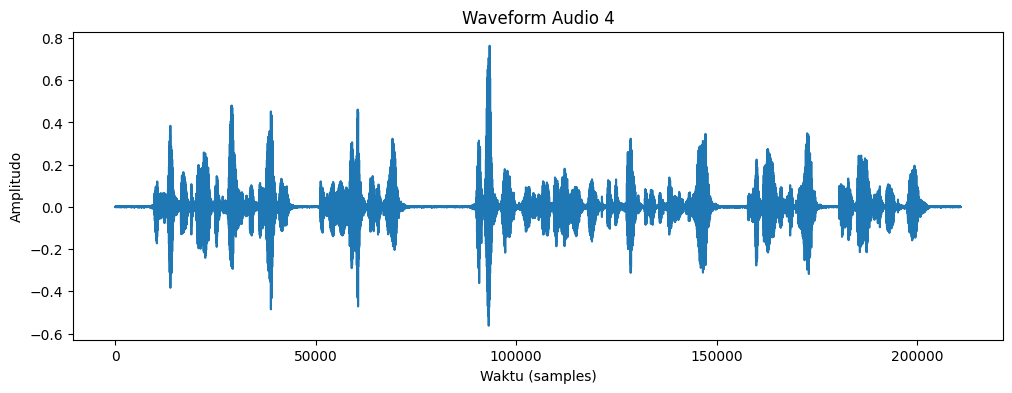

Transcript: ONLY AS HE WAS FIVE AND FIFTY AND COSETTE EIGHT YEARS OF AGE ALL THAT MIGHT HAVE BEEN LOVE IN THE WHOLE COURSE OF HIS LIFE FLOWED TOGETHER INTO A SORT OF INEFFABLE LIGHT


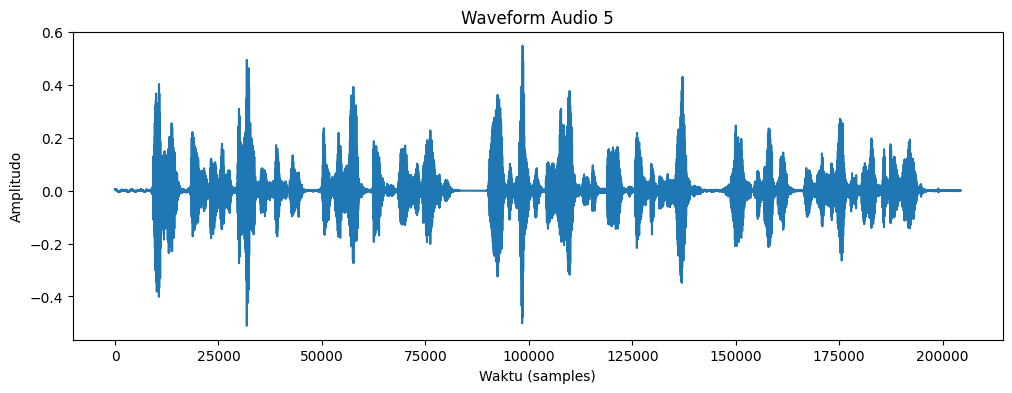

In [14]:
for i in range(5):
    waveform, sample_rate, transcript, _, _, _ = train_dataset[i]
    print(f'Transcript: {transcript}')
    plt.figure(figsize=(12, 4))
    plt.plot(waveform.t().numpy())
    plt.title(f'Waveform Audio {i+1}')
    plt.xlabel('Waktu (samples)')
    plt.ylabel('Amplitudo')
    plt.show()


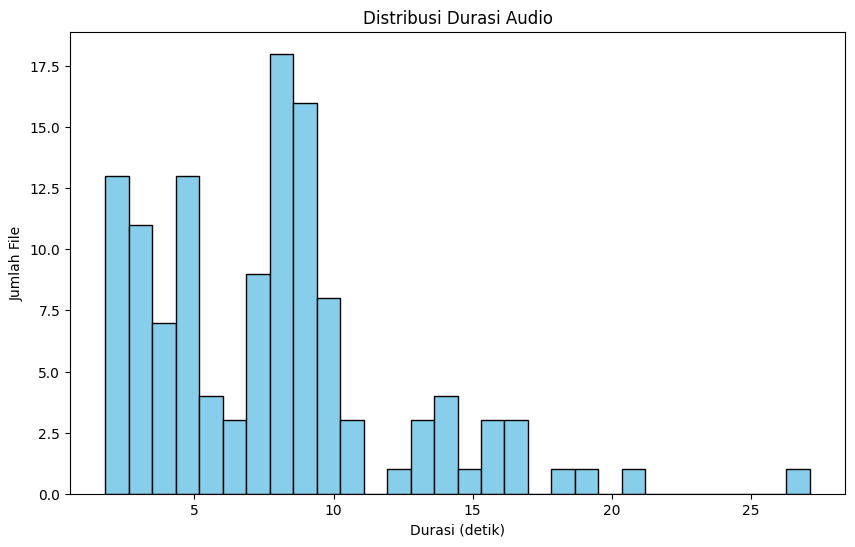

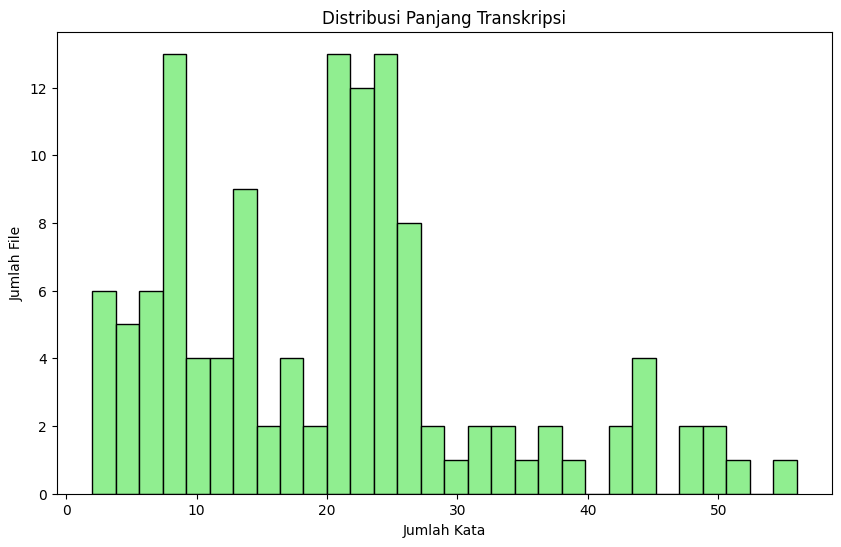

In [19]:
durations = []
transcription_lengths = []

for i in range(len(train_dataset)):  # Misal ambil 100 contoh pertama
    waveform, sample_rate, transcript, _, _, _ = train_dataset[i]
    duration = waveform.shape[1] / sample_rate  # Durasi = panjang sinyal / sample_rate
    durations.append(duration)
    transcription_lengths.append(len(transcript.split()))

# Plot histogram durasi
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Durasi Audio')
plt.xlabel('Durasi (detik)')
plt.ylabel('Jumlah File')
plt.show()

# Plot distribusi panjang transkripsi
plt.figure(figsize=(10, 6))
plt.hist(transcription_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribusi Panjang Transkripsi')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah File')
plt.show()


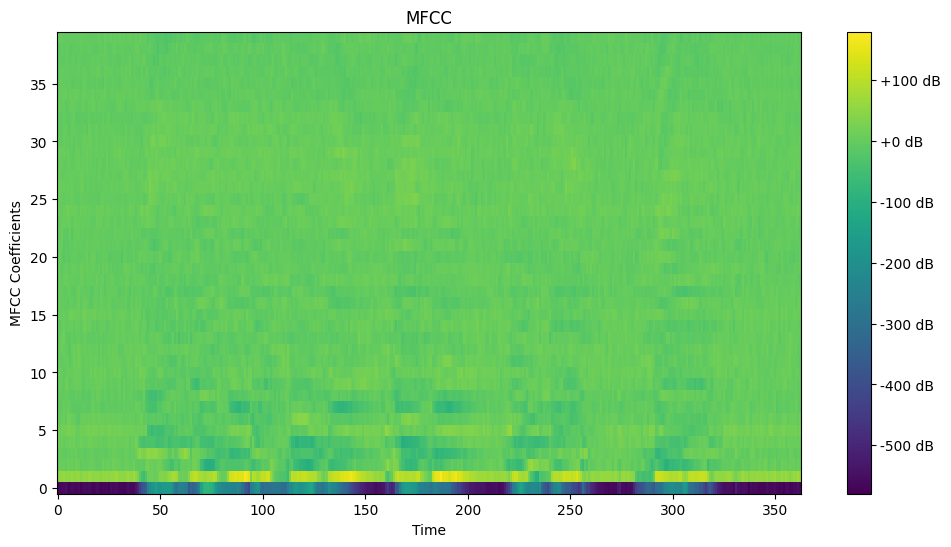

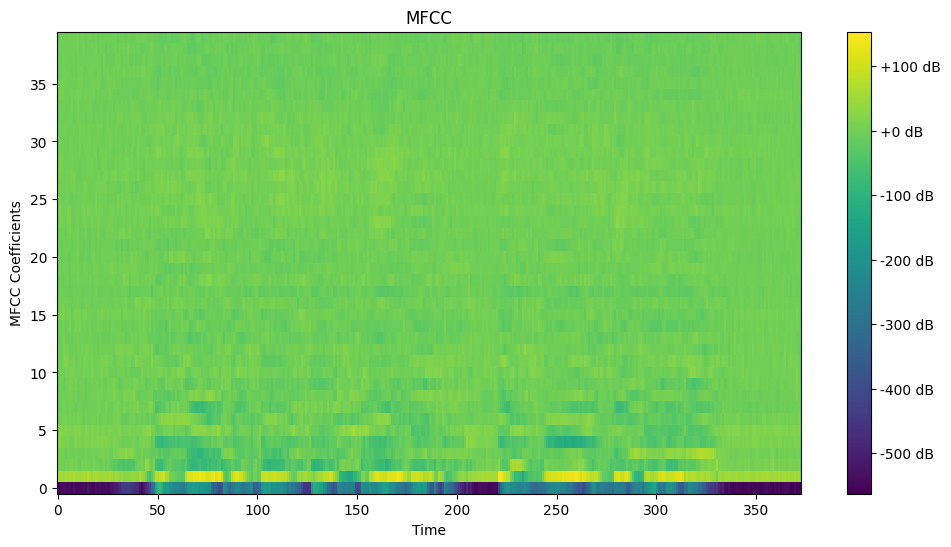

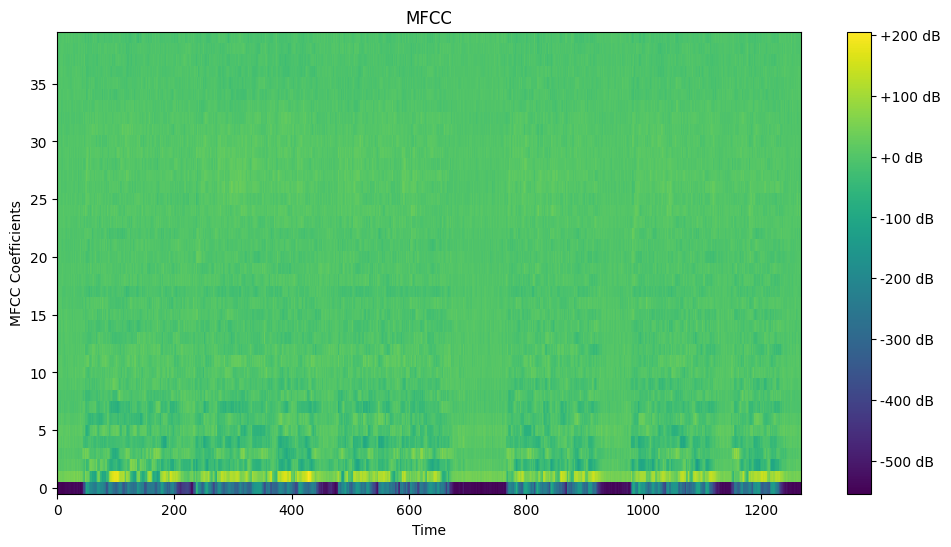

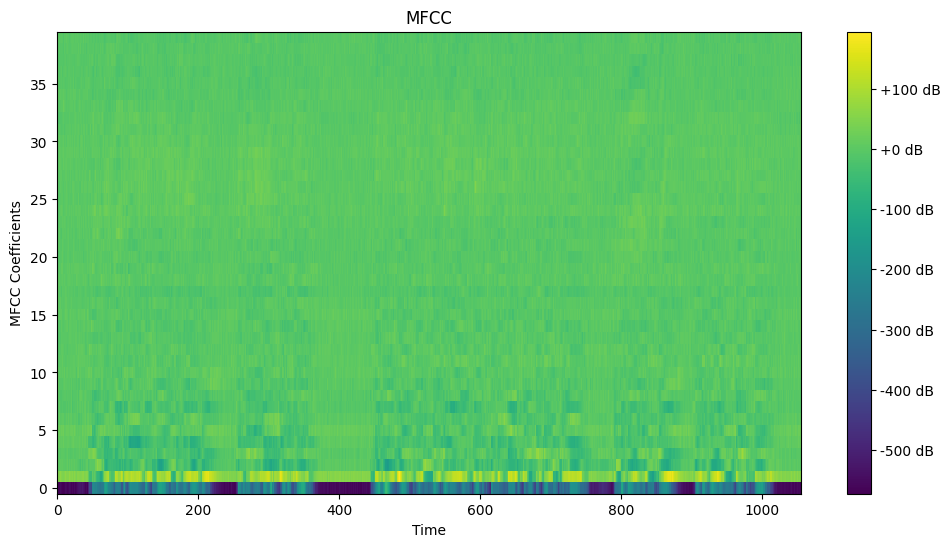

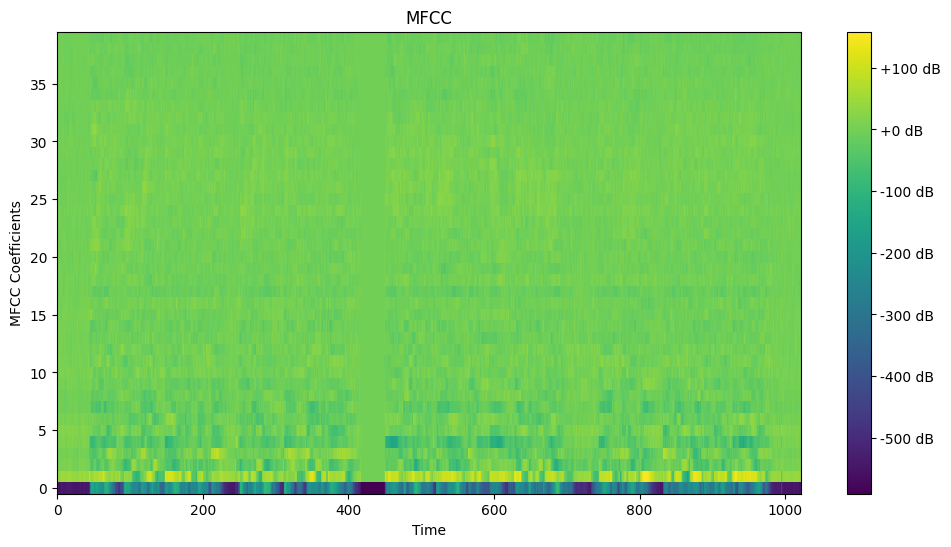

In [22]:
import torchaudio.transforms as T

for i in range(5):  # Misal ambil 100 contoh pertama
    waveform, sample_rate, transcript, _, _, _ = train_dataset[i]
    mfcc = T.MFCC()(waveform)

    # Plot MFCC
    plt.figure(figsize=(12, 6))
    plt.imshow(mfcc[0].numpy(), cmap='viridis', origin='lower', aspect='auto', interpolation='none')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from torchaudio.transforms import MelSpectrogram

# Load file audio dari dataset
waveform, sample_rate, transcript, _, _, _ = train_dataset[0]  # Ambil contoh audio pertama

# Jika waveform memiliki lebih dari 1 channel (misalnya stereo), ambil channel pertama
if waveform.shape[0] > 1:
    waveform = waveform[0, :]  # Pilih channel pertama untuk mono

# Parameter windowing
window_size = 400  # ukuran window dalam sample (sekitar 25 ms untuk sample_rate 16kHz)
hop_size = 160  # hop size dalam sample (sekitar 10 ms)
window_function = torch.hamming_window(window_size)  # Fungsi jendela Hamming

# Fungsi untuk windowing
def apply_window(waveform, window_size, hop_size, window_function):
    frames = []
    num_frames = (waveform.shape[0] - window_size) // hop_size + 1  # menghitung jumlah frame

    # Looping untuk mengambil segmen
    for i in range(num_frames):
        start = i * hop_size
        end = start + window_size
        if end <= waveform.shape[0]:  # Memastikan frame tidak keluar dari panjang waveform
            frame = waveform[start:end]  # Ambil segmen
            frame_windowed = frame * window_function  # Terapkan windowing
            frames.append(frame_windowed)

    # Pastikan bahwa frames tidak kosong
    if len(frames) > 0:
        return torch.stack(frames)
    else:
        raise ValueError("Tidak ada frame yang valid setelah windowing")

# Terapkan windowing
windowed_waveform = apply_window(waveform, window_size, hop_size, window_function)

# Visualisasi salah satu segmen setelah windowing
plt.figure(figsize=(12, 4))
plt.plot(windowed_waveform[0].numpy())  # Visualisasikan segmen pertama
plt.title("Waveform setelah Windowing (Segmen Pertama)")
plt.xlabel("Samples")
plt.ylabel("Amplitudo")
plt.show()

# Convert ke Mel Spectrogram setelah windowing (untuk visualisasi lebih lanjut)
mel_spectrogram_transform = MelSpectrogram(sample_rate=sample_rate)  # Transformasi Mel Spectrogram
mel_spectrogram = mel_spectrogram_transform(windowed_waveform[0])  # Terapkan transformasi pada segmen pertama

# Visualisasi Mel Spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(mel_spectrogram.numpy(), cmap='viridis', origin='lower', aspect='auto', interpolation='none')
plt.title('Mel Spectrogram Setelah Windowing')
plt.xlabel('Waktu (Frames)')
plt.ylabel('Frekuensi (Mel Bands)')
plt.colorbar(format='%+2.0f dB')
plt.show()


In [4]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_mels=40,
    n_fft=400,
    hop_length=160,
).to(device)

# Buat collate_fn untuk padding batch data audio dan teks
def collate_fn(batch):
    waveforms = []
    labels = []
    input_lengths = []
    label_lengths = []

    for waveform, sample_rate, transcript, _, _, _ in batch:
        waveform = waveform.to(device)
        # ekstrak fitur
        mel_spec = mel_spectrogram(waveform).squeeze(0).transpose(0, 1)  # (time, mel)
        waveforms.append(mel_spec)

        # ubah transcript ke label index
        label = text_to_index(transcript.lower())
        labels.append(torch.tensor(label, dtype=torch.long))

        input_lengths.append(mel_spec.shape[0])
        label_lengths.append(len(label))

    # Pad input fitur (waveforms) dan label (teks)
    waveforms = nn.utils.rnn.pad_sequence(waveforms, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

    return waveforms, labels, torch.tensor(input_lengths), torch.tensor(label_lengths)

# Map karakter ke index (tokenizer sederhana)
char_map_str = " abcdefghijklmnopqrstuvwxyz'"
char_map = {c: i + 1 for i, c in enumerate(char_map_str)}  # 0 untuk padding

def text_to_index(text):
    return [char_map.get(c, 0) for c in text]

def index_to_text(indices):
    inv_map = {v: k for k, v in char_map.items()}
    return "".join([inv_map.get(i, "") for i in indices])

# Dataset dan DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

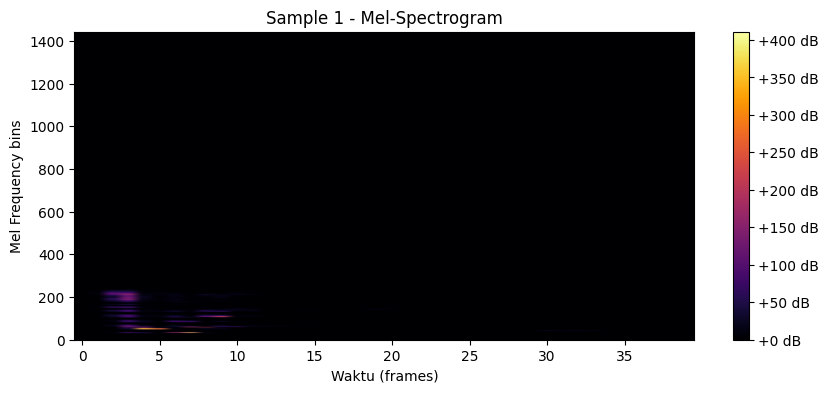

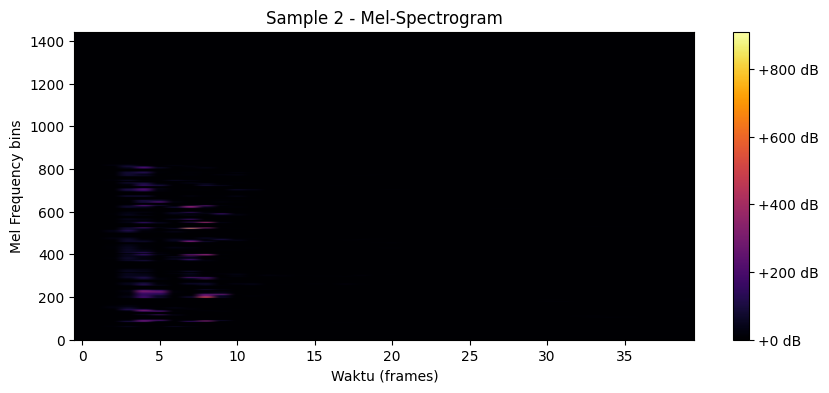

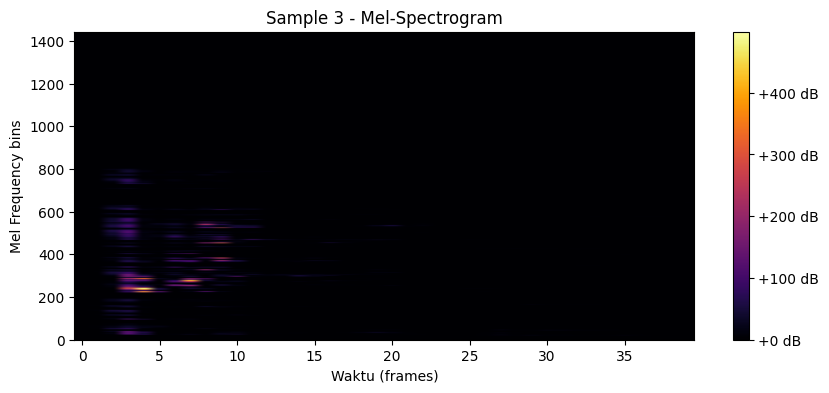

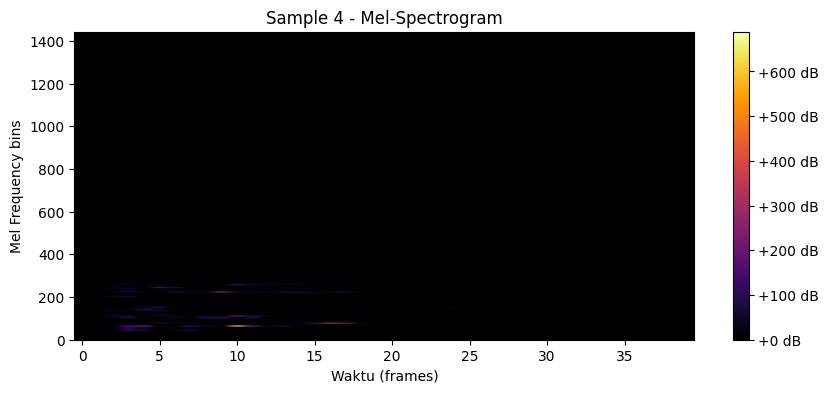

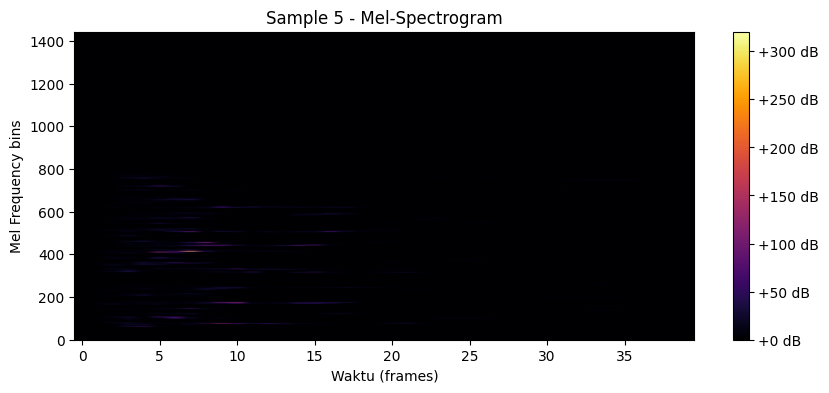

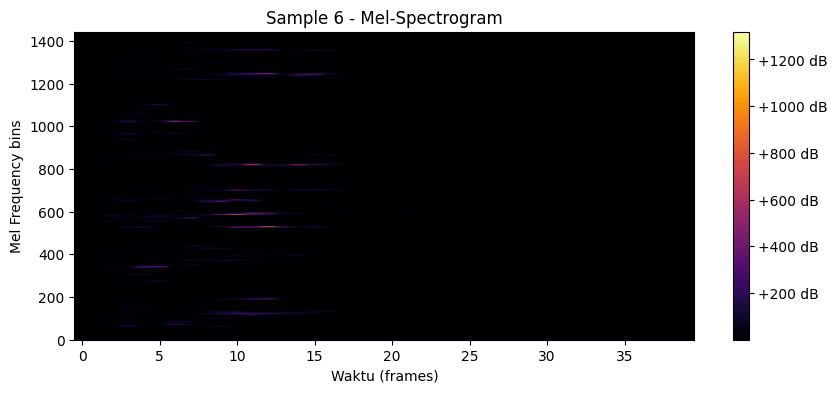

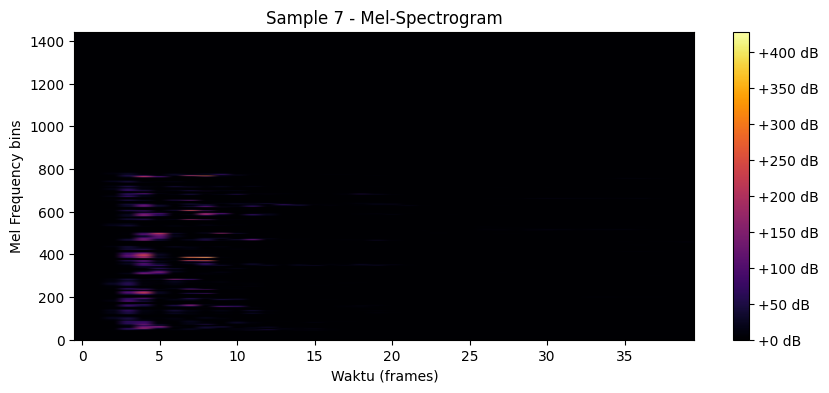

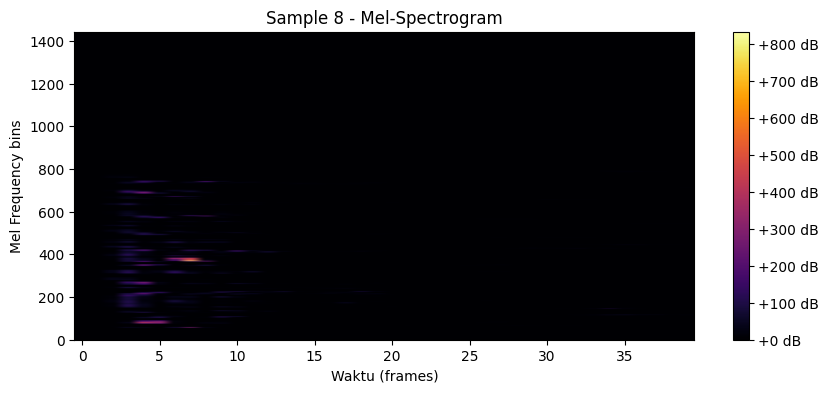

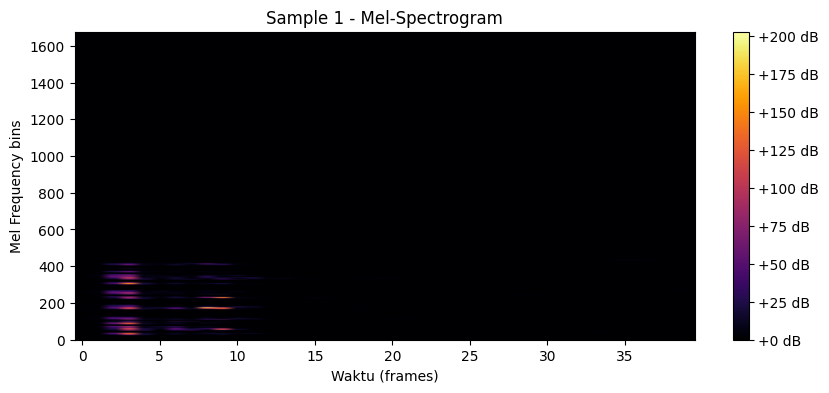

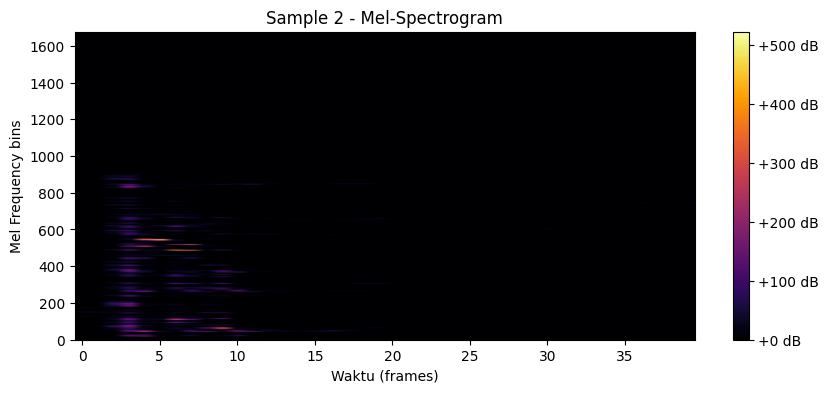

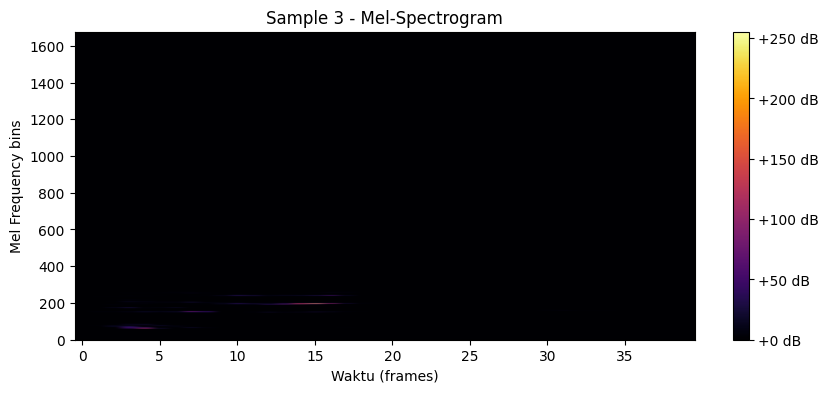

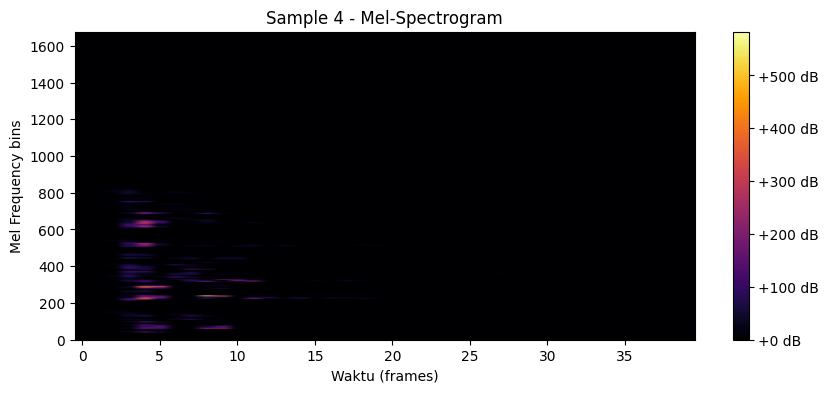

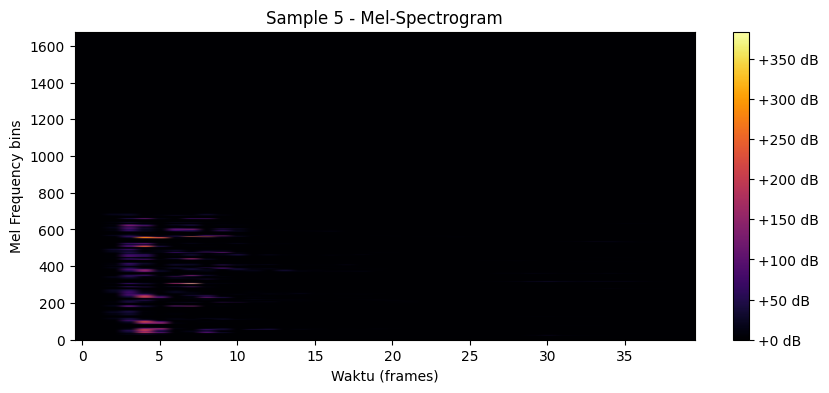

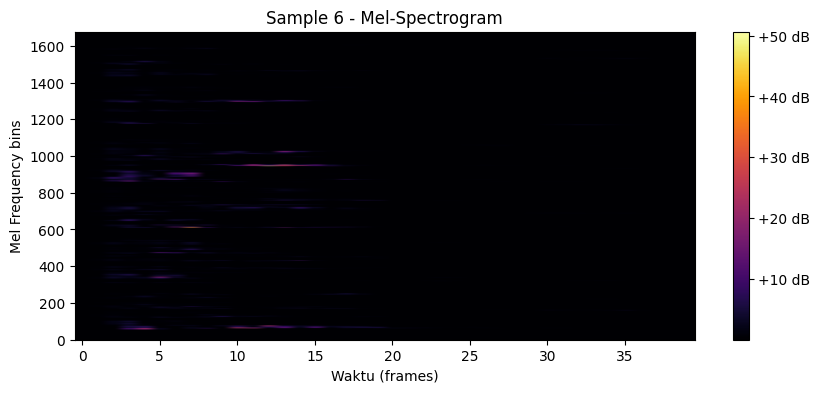

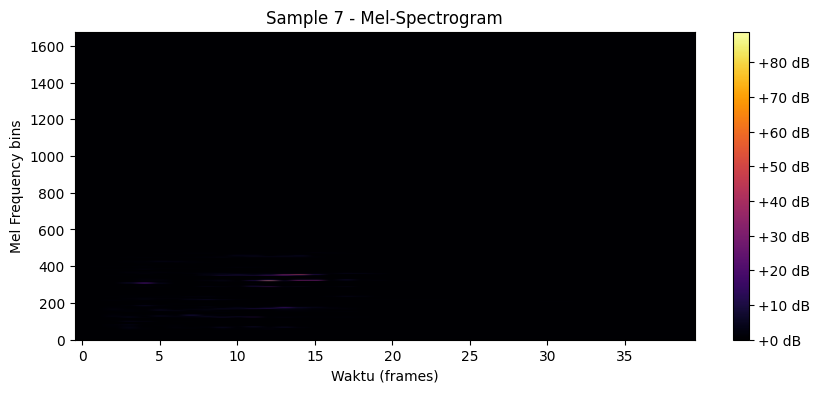

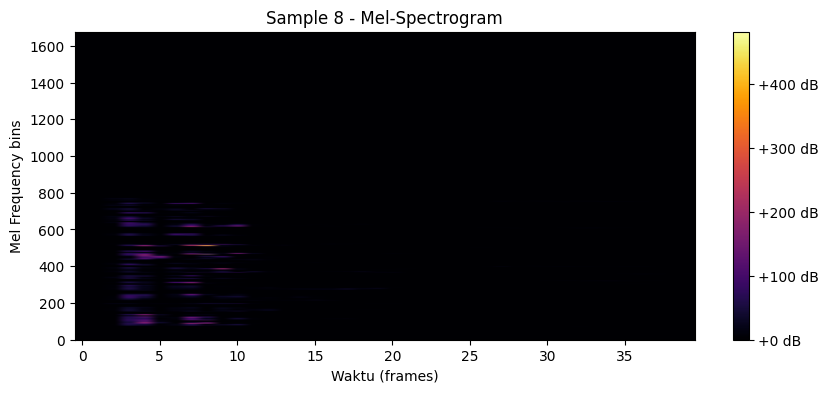

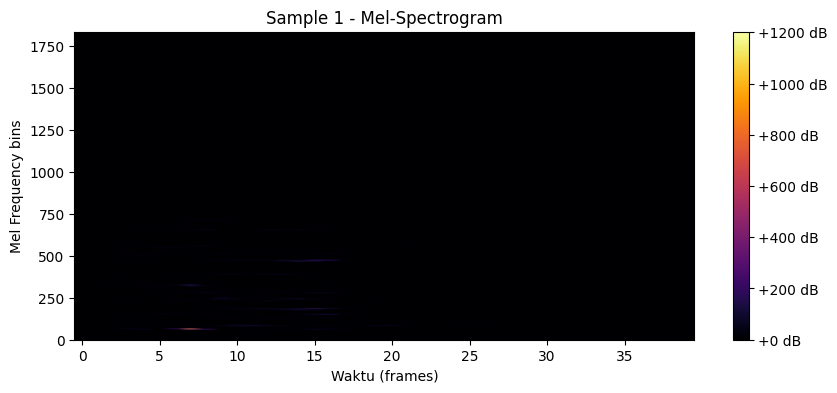

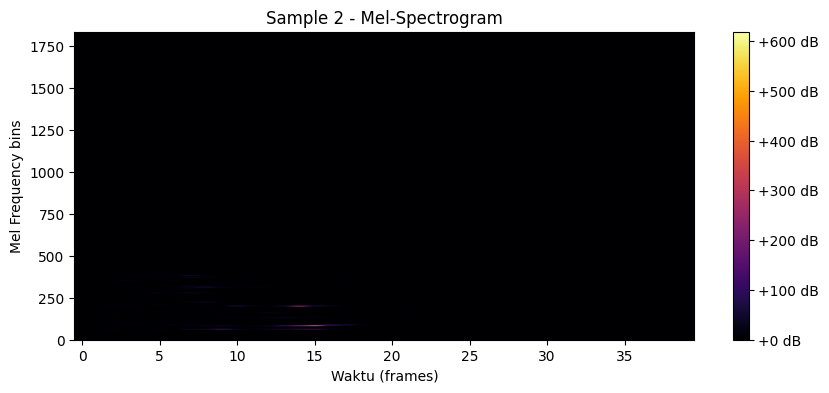

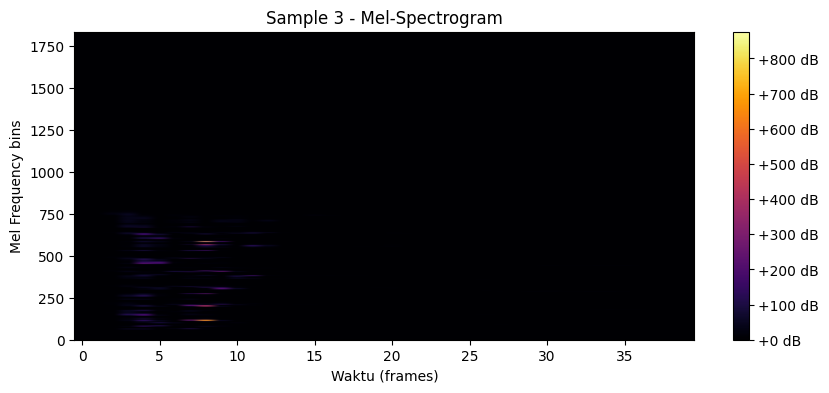

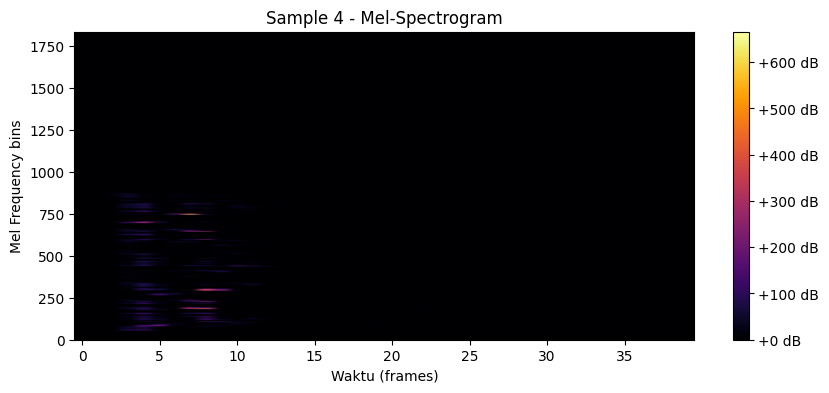

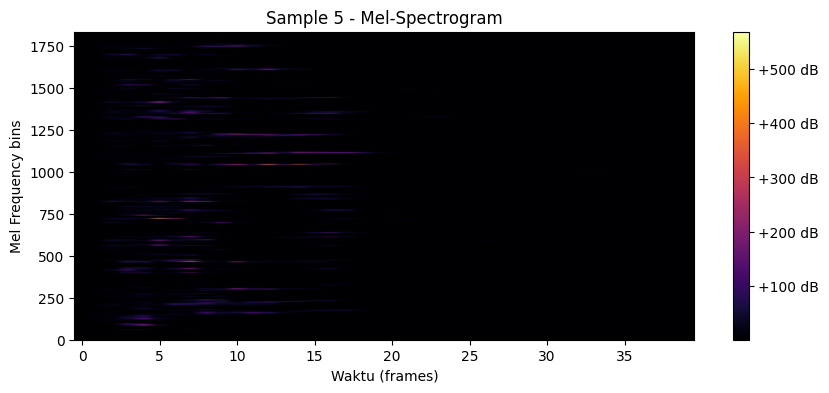

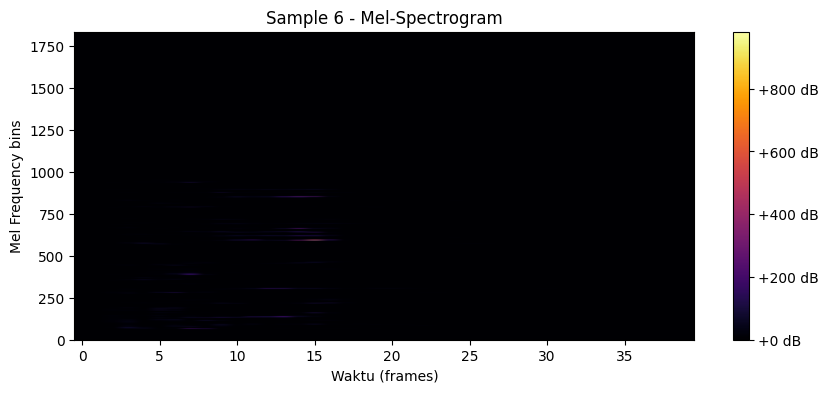

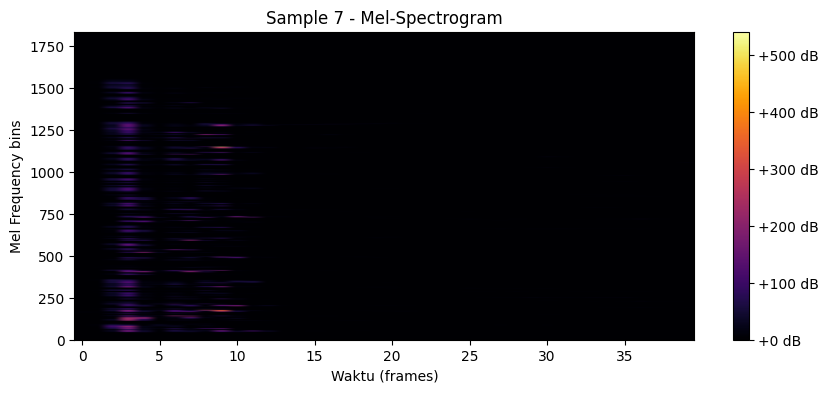

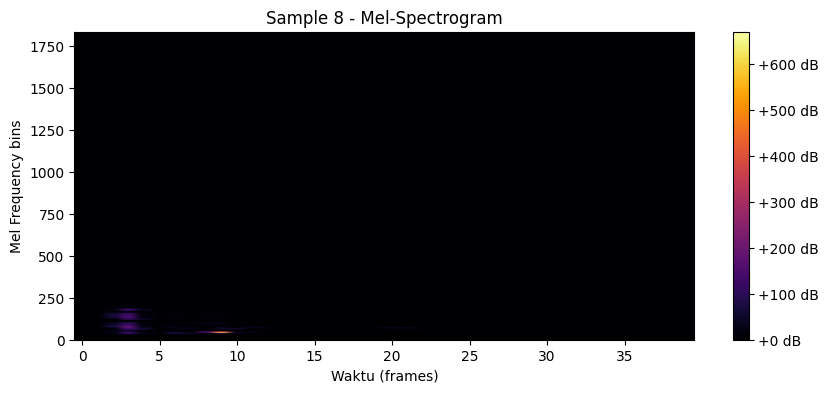

In [6]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH
import torch.nn as nn

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MelSpectrogram transform
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_mels=40,
    n_fft=400,
    hop_length=160,
).to(device)

# Buat collate_fn untuk padding batch data audio dan teks
def collate_fn(batch):
    waveforms = []
    labels = []
    input_lengths = []
    label_lengths = []

    for waveform, sample_rate, transcript, _, _, _ in batch:
        waveform = waveform.to(device)
        # ekstrak fitur
        mel_spec = mel_spectrogram(waveform).squeeze(0).transpose(0, 1)  # (time, mel)
        waveforms.append(mel_spec)

        # ubah transcript ke label index
        label = text_to_index(transcript.lower())
        labels.append(torch.tensor(label, dtype=torch.long))

        input_lengths.append(mel_spec.shape[0])
        label_lengths.append(len(label))

    # Pad input fitur (waveforms) dan label (teks)
    waveforms = nn.utils.rnn.pad_sequence(waveforms, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

    return waveforms, labels, torch.tensor(input_lengths), torch.tensor(label_lengths)

# Map karakter ke index (tokenizer sederhana)
char_map_str = " abcdefghijklmnopqrstuvwxyz'"
char_map = {c: i + 1 for i, c in enumerate(char_map_str)}  # 0 untuk padding

def text_to_index(text):
    return [char_map.get(c, 0) for c in text]

def index_to_text(indices):
    inv_map = {v: k for k, v in char_map.items()}
    return "".join([inv_map.get(i, "") for i in indices])

# Dataset dan DataLoader
train_dataset = LIBRISPEECH("./datasets", url="dev-clean", download=False)
test_dataset = LIBRISPEECH("./datasets", url="test-clean", download=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Fungsi untuk visualisasi Mel-Spectrogram
def plot_mel_spectrogram(mel_spec, title="Mel-Spectrogram"):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel("Waktu (frames)")
    plt.ylabel("Mel Frequency bins")
    plt.show()

# Ambil beberapa sampel dari DataLoader dan tampilkan Mel-Spectrogram
for i, (waveforms, labels, input_lengths, label_lengths) in enumerate(train_loader):
    if i >= 3:  # Menampilkan 3 batch pertama
        break
    for j in range(waveforms.size(0)):  # Iterasi setiap sample dalam batch
        mel_spec = waveforms[j]  # Ambil Mel-Spectrogram untuk sample j
        plot_mel_spectrogram(mel_spec, title=f"Sample {j+1} - Mel-Spectrogram")


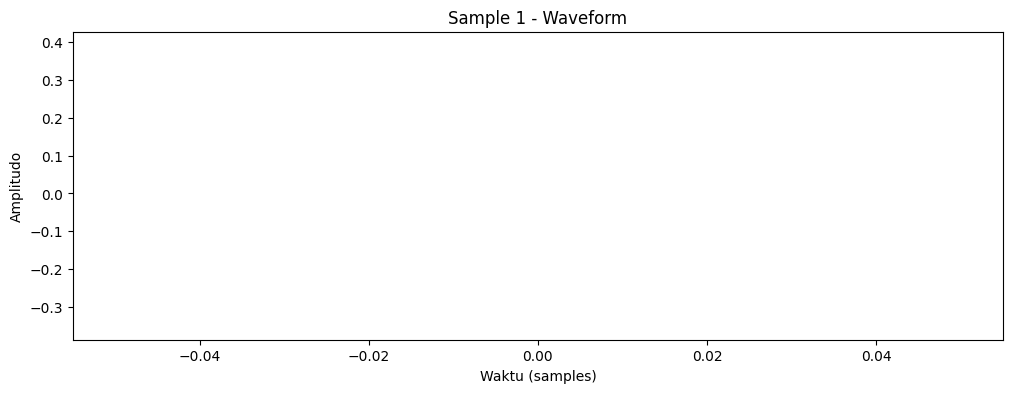

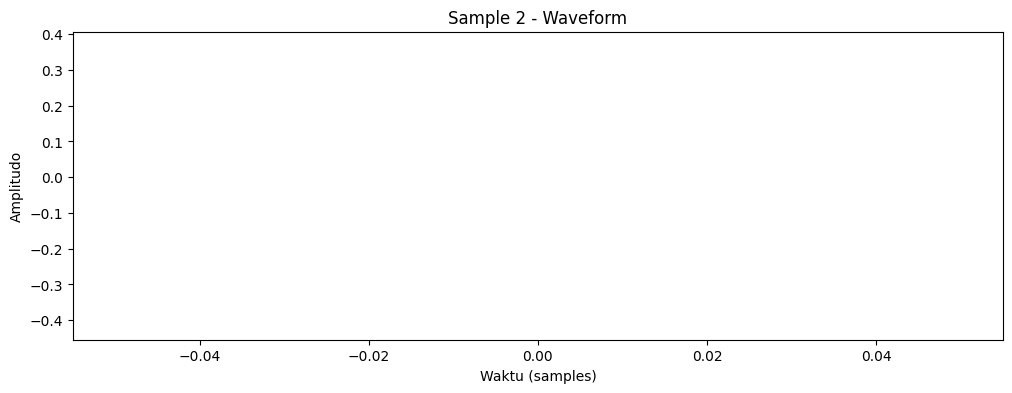

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1119eb200>>
Traceback (most recent call last):
  File "/Users/kuldii/Downloads/KULDI PROJECT/PROJECT/JIR (Jepang, Indo, Rusia)/CODE/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH
import torch.nn as nn
import torch.nn.functional as F

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset dan DataLoader
train_dataset = LIBRISPEECH("./datasets", url="dev-clean", download=False)
test_dataset = LIBRISPEECH("./datasets", url="test-clean", download=False)

# Fungsi untuk visualisasi waveform audio
def plot_waveform(audio, title="Waveform"):
    plt.figure(figsize=(12, 4))
    plt.plot(audio.cpu().numpy())
    plt.title(title)
    plt.xlabel("Waktu (samples)")
    plt.ylabel("Amplitudo")
    plt.show()

# Buat collate_fn untuk padding batch data audio dan teks
def collate_fn(batch):
    waveforms = []
    labels = []
    input_lengths = []
    label_lengths = []

    # Menemukan panjang waveform maksimum
    max_waveform_len = max([waveform.size(1) for waveform, _, _, _, _, _ in batch])

    for waveform, sample_rate, transcript, _, _, _ in batch:
        waveform = waveform.to(device)

        # Padding manual pada dimensi kedua (panjang waktu) agar semua waveform memiliki panjang yang sama
        if waveform.size(1) < max_waveform_len:
            # Padding dengan nol (zero padding) di akhir audio untuk menyamakan panjang
            padding = max_waveform_len - waveform.size(1)
            waveform = F.pad(waveform, (0, padding))

        waveforms.append(waveform)

        # Ubah transcript ke label index
        label = text_to_index(transcript.lower())
        labels.append(torch.tensor(label, dtype=torch.long))

        input_lengths.append(waveform.shape[1])
        label_lengths.append(len(label))

    # Pad input fitur (waveforms) dan label (teks)
    waveforms = torch.stack(waveforms, dim=0)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

    return waveforms, labels, torch.tensor(input_lengths), torch.tensor(label_lengths)

# Map karakter ke index (tokenizer sederhana)
char_map_str = " abcdefghijklmnopqrstuvwxyz'"
char_map = {c: i + 1 for i, c in enumerate(char_map_str)}  # 0 untuk padding

def text_to_index(text):
    return [char_map.get(c, 0) for c in text]

def index_to_text(indices):
    inv_map = {v: k for k, v in char_map.items()}
    return "".join([inv_map.get(i, "") for i in indices])

# DataLoader untuk training dataset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Ambil beberapa sampel dari DataLoader dan tampilkan gelombang audio
for i, (waveforms, labels, input_lengths, label_lengths) in enumerate(train_loader):
    if i >= 3:  # Menampilkan 3 batch pertama
        break
    for j in range(waveforms.size(0)):  # Iterasi setiap sample dalam batch
        waveform = waveforms[j]  # Ambil gelombang audio untuk sample j
        plot_waveform(waveform, title=f"Sample {j+1} - Waveform")
